# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv('../data/raw/KAG_conversion_data.csv')

In [2]:
def filter_interest(df, column_name, threshold=0.8, new_column_name='filtered_interest'):
    value_counts = df[column_name].value_counts()
    total_count = value_counts.sum()
    cum_count = 0
    keep_values = []

    for value, count in value_counts.items():
        cum_count += count
        if cum_count / total_count <= threshold:
            keep_values.append(value)
        else:
            break

    filtered_df = df.copy()
    filtered_df[new_column_name] = filtered_df[column_name].apply(lambda x: x if x in keep_values else 'other')
    return filtered_df

In [3]:
df = filter_interest(df, 'interest', threshold=0.8, new_column_name='pareto_interest')
df1 = df


In [4]:
df['conv1'] = np.where(df['Total_Conversion'] != 0, 1, 0)
df['conv2'] = np.where(df['Approved_Conversion'] != 0, 1, 0)

In [5]:
columns_to_one_hot_encode = ['pareto_interest', 'gender','age']  # Add all columns you want to encode

dis_interest = df['pareto_interest'].unique()
dis_gender = df['gender'].unique()
dis_age = df['age'].unique()


# Use get_dummies to create dummy variables for specified columns
df_dummies = pd.get_dummies(df[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
df = pd.concat([df, df_dummies], axis=1)

In [6]:
df2 = df.drop(['age', 'gender', 'xyz_campaign_id', 'fb_campaign_id', 'interest', 'pareto_interest'], axis=1).set_index('ad_id')

c:\Users\ADMIN\Documents\school\Sales-Conversion-Optimization-Project\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


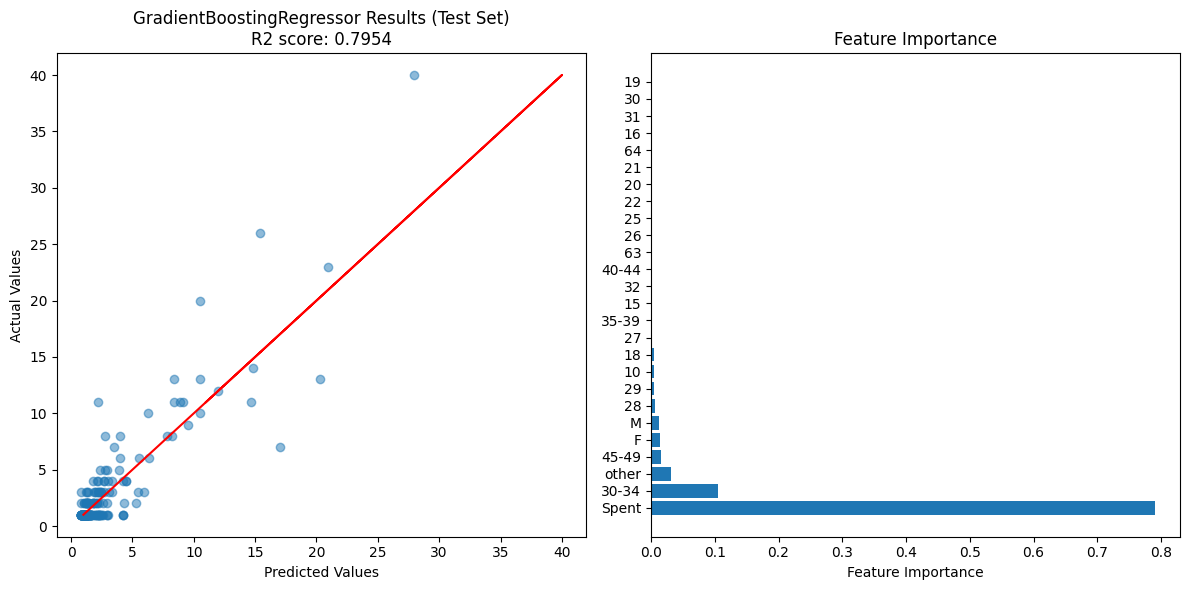

In [7]:
# Prepare the data
X = df2.drop(['Total_Conversion', 'Approved_Conversion', 'conv1', 'conv2', 'Impressions', 'Clicks'], axis=1)
Y = df2[['Total_Conversion']]

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the XGBoost regression model
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)

# Calculate R2 score for the training set
Y_train_pred = model.predict(X_train)
r2_train = r2_score(Y_train, Y_train_pred)

# Calculate R2 score for the test set
Y_test_pred = model.predict(X_test)
r2_test = r2_score(Y_test, Y_test_pred)

# Plot the predicted values vs. actual values and feature importance
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted vs. actual values for the test set
ax[0].scatter(Y_test_pred, Y_test, alpha=0.5)
ax[0].plot(Y_test, Y_test, color='red')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Actual Values')
ax[0].set_title(f'GradientBoostingRegressor Results (Test Set)\nR2 score: {r2_test:.4f}')

# Plot feature importance
feature_importance = model.feature_importances_
sorted_indices = feature_importance.argsort()[::-1]  # Sort feature indices in descending order
sorted_features = X.columns[sorted_indices]  # Sort feature names based on indices

ax[1].barh(range(len(feature_importance)), feature_importance[sorted_indices])
ax[1].set_yticks(range(len(feature_importance)))
ax[1].set_yticklabels(sorted_features)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

In [8]:
combinations = []

# Lặp qua từng giá trị và tạo tổ hợp
for age in dis_age:
    for gender in dis_gender:
        for interest in dis_interest:
            # Thêm tổ hợp vào danh sách
            combinations.append({'age': age, 'gender': gender, 'pareto_interest': interest})

# Chuyển đổi danh sách thành DataFrame
df_combinations = pd.DataFrame(combinations)



In [9]:

# Use get_dummies to create dummy variables for specified columns
df_combinations = pd.get_dummies(df_combinations[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_combinations.select_dtypes(include='bool').columns
df_combinations[boolean_columns] = df_combinations[boolean_columns].astype(int)
df_combinations.insert(0, 'Spent', 0)



In [10]:
df_combinations['Spent'] = 600

pred = model.predict(df_combinations)

max_index = np.argmax(pred)
max_value = pred[max_index]

# Lấy cấu hình đầu vào tương ứng
best_config = df_combinations.iloc[max_index]  # Sử dụng iloc để truy xuất hàng theo chỉ số

# In ra kết quả
print(f"Cấu hình đầu vào tối ưu: {best_config}")
print(f"Giá trị ROI dự đoán tối đa: {max_value:.4f}")

Cấu hình đầu vào tối ưu: Spent    600
10         0
15         0
16         0
18         0
19         0
20         0
21         0
22         0
25         0
26         0
27         0
28         0
29         1
30         0
31         0
32         0
63         0
64         0
other      0
F          0
M          1
30-34      1
35-39      0
40-44      0
45-49      0
Name: 4, dtype: int64
Giá trị ROI dự đoán tối đa: 31.3600
